In [146]:
import numpy as np
from phimal_utilities.analysis import load_tensorboard

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='white')

In [147]:
df_deepmod = load_tensorboard('runs/deepmod/')
df_logprob= load_tensorboard('runs/logprob/')
df_logprob_scaled = load_tensorboard('runs/logprob_scaled/')

In [148]:
df_logprob_scaled.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11',
       'log_likelihood', 'll_fit'],
      dtype='object')

In [149]:
true_coeffs = np.zeros((1, 12))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 5] = -1.0

In [150]:
coeff_keys = [key for key in df_deepmod.keys() if key[:5]=='coeff']

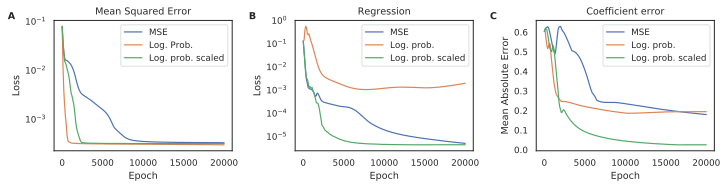

In [151]:
%config InlineBackend.figure_format = 'svg'

sns.set_context('paper')
sns.set_style('white')

fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=3, constrained_layout=True) #5.5 is official width

# Left panel
ax = axes[0]
ax.plot(df_deepmod.index, df_deepmod['MSE_0'], label='MSE')
ax.plot(df_logprob.index, df_logprob['MSE_0'], label='Log. Prob.')
ax.plot(df_logprob_scaled.index, df_logprob_scaled['MSE_0'], label='Log. prob. scaled')

ax.legend()
ax.set_yscale('log')
ax.set_title('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.text(-0.26, 1.01, 'A', transform=ax.transAxes, weight='bold')

# Middle panel
ax = axes[1]
ax.plot(df_deepmod.index, df_deepmod['Regression_0'], label='MSE')
ax.plot(df_logprob.index, df_logprob['Regression_0'], label='Log. prob.')
ax.plot(df_logprob_scaled.index, df_logprob_scaled['Regression_0'], label='Log. prob. scaled')

ax.legend()
ax.set_yscale('log')
ax.set_title('Regression')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.text(-0.26, 1.01, 'B', transform=ax.transAxes, weight='bold')

# Right panel
ax = axes[2]
ax.plot(df_deepmod.index, np.mean(np.abs(df_deepmod[coeff_keys] - true_coeffs), axis=1), label='MSE')
ax.plot(df_logprob.index, np.mean(np.abs(df_logprob[coeff_keys] - true_coeffs), axis=1), label='Log. prob.')
ax.plot(df_logprob_scaled.index, np.mean(np.abs(df_logprob_scaled[coeff_keys] - true_coeffs), axis=1), label='Log. prob. scaled')
ax.set_title('Coefficient error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.text(-0.26, 1.01, 'C', transform=ax.transAxes, weight='bold')
ax.legend()

#fig.show()
plt.savefig('figure_1.pdf')

# Loading multiple runs

In [2]:
import numpy as np
from phimal_utilities.analysis import load_tensorboard
from os import listdir
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='white')


In [3]:
def collect_runs(ID, true_coeffs):
    files = [file for file in listdir('runs_new') if file[:len(ID)] == ID]
    files.sort()
    print(files)
    dfs = [load_tensorboard('runs_new/' + file + '/') for file in files]
    
    df_plot = pd.DataFrame(index=dfs[0].index)
    
    # Setting MSE and Reg properties
    MSE = np.log10(np.stack([df['MSE_0'] for df in dfs], axis=1)) # take mean of log ipv log of mean for visualization purposes
    Reg = np.log10(np.stack([df['Regression_0'] for df in dfs], axis=1))
    
    df_plot['MSE_mean'] = np.mean(MSE, axis=1)
    df_plot['MSE_std'] = np.std(MSE, axis=1)
    df_plot['Reg_mean'] = np.mean(Reg, axis=1)
    df_plot['Reg_std'] = np.std(Reg, axis=1)
    
    # Coefficient error 
    coeff_keys = [key for key in dfs[0].keys() if key[:6]=='scaled'] # take error w.r.t scaled coeffs
    coeff_errors = np.log10(np.stack([np.mean(np.abs(df[coeff_keys] - true_coeffs), axis=1) for df in dfs], axis=1))
    df_plot['Coeff_mean'] = np.mean(coeff_errors, axis=1)
    df_plot['Coeff_std'] = np.std(coeff_errors, axis=1)
    
    # Library error
    mae_keys = [key for key in dfs[0].keys() if key[:3]=='mae']
    lib_errors = np.log10(np.stack([np.mean(np.abs(df[mae_keys]), axis=1) for df in dfs], axis=1)) # mean over all coeffs
    df_plot['library_mean'] = np.mean(lib_errors, axis=1) # means over runs
    df_plot['library_std'] = np.std(lib_errors, axis=1)
    
    return df_plot

In [4]:
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

In [5]:
true_coeffs = np.zeros((1, 12))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 5] = -1.0

In [6]:
# Making grid
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

# Making data
dataset = Dataset(BurgersDelta, v=0.1, A=1.0)
theta = dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), poly_order=2, deriv_order=3)
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))

In [7]:
true_coeffs_scaled = true_coeffs * np.linalg.norm(theta, axis=0) / np.linalg.norm(dt)

In [8]:
true_coeffs_scaled

array([[ 0.        ,  0.        ,  0.64779762,  0.        ,  0.        ,
        -0.93302594,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [9]:
df_deepmod = collect_runs('deepmod_run', true_coeffs=true_coeffs_scaled)
df_logprob = collect_runs('deepmod_logprob_run', true_coeffs=true_coeffs_scaled)
df_logprob_scaled = collect_runs('deepmod_logprob_scaled_run', true_coeffs=true_coeffs_scaled)

['deepmod_run_0', 'deepmod_run_1', 'deepmod_run_2', 'deepmod_run_3', 'deepmod_run_4']


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

['deepmod_logprob_run_0', 'deepmod_logprob_run_1', 'deepmod_logprob_run_2', 'deepmod_logprob_run_3', 'deepmod_logprob_run_4']
['deepmod_logprob_scaled_run_0', 'deepmod_logprob_scaled_run_1', 'deepmod_logprob_scaled_run_2', 'deepmod_logprob_scaled_run_3', 'deepmod_logprob_scaled_run_4']


In [10]:
df_deepmod.keys()

Index(['MSE_mean', 'MSE_std', 'Reg_mean', 'Reg_std', 'Coeff_mean', 'Coeff_std',
       'library_mean', 'library_std'],
      dtype='object')

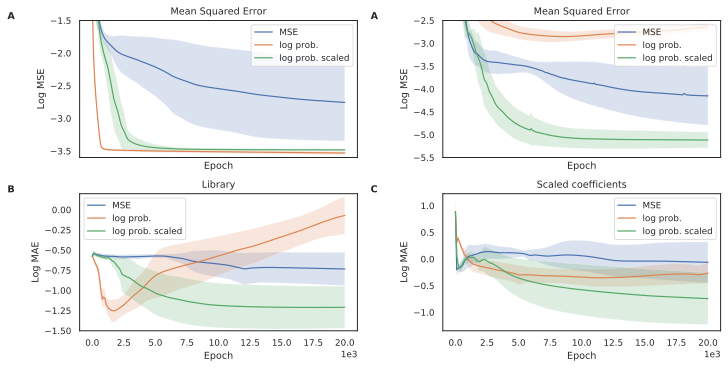

In [18]:
%config InlineBackend.figure_format = 'svg'

sns.set_context('paper')
sns.set_style('white')

fig, axes = plt.subplots(figsize=(10, 5), nrows=2, ncols=2, constrained_layout=True, sharex=True) #5.5 is official width

# Left panel
ax = axes[0, 0]

ax.fill_between(df_deepmod.index, df_deepmod['MSE_mean']-df_deepmod['MSE_std'], df_deepmod['MSE_mean']+df_deepmod['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['MSE_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['MSE_mean']-df_logprob['MSE_std'], df_logprob['MSE_mean']+df_logprob['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['MSE_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['MSE_mean']-df_logprob_scaled['MSE_std'], df_logprob_scaled['MSE_mean']+df_logprob_scaled['MSE_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['MSE_mean'], label='log prob. scaled')

ax.legend()
ax.set_title('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log MSE')
ax.text(-0.26, 1.01, 'A', transform=ax.transAxes, weight='bold')
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax.set_ylim([-3.6, -1.5])


# Right panel
ax = axes[0, 1]

ax.fill_between(df_deepmod.index, df_deepmod['Reg_mean']-df_deepmod['Reg_std'], df_deepmod['Reg_mean']+df_deepmod['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['Reg_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['Reg_mean']-df_logprob['Reg_std'], df_logprob['Reg_mean']+df_logprob['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['Reg_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['Reg_mean']-df_logprob_scaled['Reg_std'], df_logprob_scaled['Reg_mean']+df_logprob_scaled['Reg_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['Reg_mean'], label='log prob. scaled')

ax.legend(loc='upper right')
ax.set_title('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log MSE')
ax.text(-0.26, 1.01, 'A', transform=ax.transAxes, weight='bold')
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax.set_ylim([-5.5, -2.5])


# Right panel
ax = axes[1, 0]
ax.fill_between(df_deepmod.index, df_deepmod['library_mean']-df_deepmod['library_std'], df_deepmod['library_mean']+df_deepmod['library_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['library_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['library_mean']-df_logprob['library_std'], df_logprob['library_mean']+df_logprob['library_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['library_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['library_mean']-df_logprob_scaled['library_std'], df_logprob_scaled['library_mean']+df_logprob_scaled['library_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['library_mean'], label='log prob. scaled')

ax.set_title('Library')
ax.set_xlabel('Epoch')
ax.set_ylim([-1.5, 0.2])
ax.set_ylabel('Log MAE')
ax.text(-0.26, 1.01, 'B', transform=ax.transAxes, weight='bold')
ax.legend(loc = 'upper left')
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

# Lower right
ax = axes[1, 1]
ax.fill_between(df_deepmod.index, df_deepmod['Coeff_mean']-df_deepmod['Coeff_std'], df_deepmod['Coeff_mean']+df_deepmod['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_deepmod['Coeff_mean'], label='MSE')

ax.fill_between(df_deepmod.index, df_logprob['Coeff_mean']-df_logprob['Coeff_std'], df_logprob['Coeff_mean']+df_logprob['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob['Coeff_mean'], label='log prob.')

ax.fill_between(df_deepmod.index, df_logprob_scaled['Coeff_mean']-df_logprob_scaled['Coeff_std'], df_logprob_scaled['Coeff_mean']+df_logprob_scaled['Coeff_std'], alpha=0.2)
ax.plot(df_deepmod.index, df_logprob_scaled['Coeff_mean'], label='log prob. scaled')

ax.set_title('Scaled coefficients')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log MAE')
ax.text(-0.26, 1.01, 'C', transform=ax.transAxes, weight='bold')
ax.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
#ax.set_ylim([-1.5, 0.5])

fig.show()
plt.savefig('figure_1.pdf')

In [208]:
#df = load_tensorboard('runs_new/deepmod_logprob_run_1/')
df = load_tensorboard('runs_new/deepmod_logprob_scaled_run_0/')
#df = load_tensorboard('runs_new/deepmod_run_0/')

In [209]:
df.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11',
       'lstsq_solution_0', 'lstsq_solution_1', 'lstsq_solution_2',
       'lstsq_solution_3', 'lstsq_solution_4', 'lstsq_solution_5',
       'lstsq_solution_6', 'lstsq_solution_7', 'lstsq_solution_8',
       'lstsq_solution_9', 'lstsq_solution_10', 'lstsq_solution_11',
       'mae_library_0', 'mae_library_1', 'mae_library_2', 'mae_library_3',
       'mae_library_4', 'mae_library_5', 'mae_library_6', 'mae_library_7',
       'mae_library_8', 'mae_library_9', 'mae_library_10', 'mae_library_11',
       

In [210]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6]=='scaled']
mae_keys = [key for key in df.keys() if key[:3]=='mae']

In [211]:
np.argmin(np.mean(df[mae_keys], axis=1))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


8600

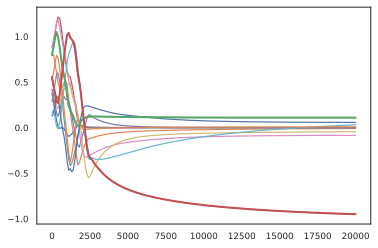

In [212]:
plt.plot(df[coeff_keys])
plt.plot(df[coeff_keys[2]], linewidth=2)
plt.plot(df[coeff_keys[5]], linewidth=2)

(-2, 2)

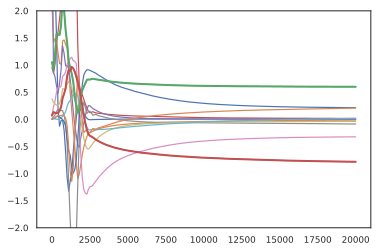

In [213]:
plt.plot(df[scaled_coeff_keys])
plt.plot(df[scaled_coeff_keys[2]], linewidth=2)
plt.plot(df[scaled_coeff_keys[5]], linewidth=2)

plt.ylim([-2, 2])

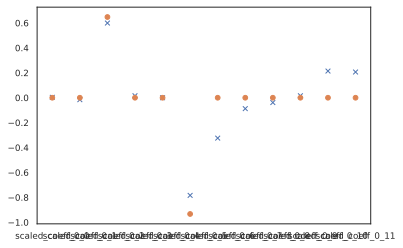

In [214]:
plt.plot(df[scaled_coeff_keys].iloc[-1], 'x')
plt.plot(true_coeffs_scaled.squeeze(), 'o')

